# Classifier for unsupervised learning

An autoencoder can work when you're dealing with exclusive production particles like vector mesons (e.g., two, three, or four particles in exclusive production) and aiming to detect new, unexpected signals like pentaquarks or tetraquarks. The autoencoder will learn the patterns of the most frequent particle combinations (two, three, or four particles) and identify any rare or unexpected combinations as anomalies based on their reconstruction error.

In this example, we will assume a dataset of tracks or particles identified in a detector, with features like energy, momentum, and invariant mass, to simulate various possible combinations of exclusive production processes

### Step 1: Setup the Environment
We will generate synthetic data that mimics typical particle production processes, such as two- or three-body decays, and occasionally introduce anomalous events like pentaquark or tetraquark signatures (but without explicitly labeling them).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Random seed for reproducibility
np.random.seed(42)

# Generate synthetic particle physics data
# Let's assume 5 features per event: [energy, momentum_x, momentum_y, momentum_z, invariant_mass]

def generate_exclusive_particles(n_samples, n_particles):
    """
    Generate synthetic exclusive particle events.
    n_particles is the number of particles in the exclusive process (2, 3, 4, etc.).
    """
    # Example: each particle in an event has some energy, momentum, and invariant mass
    events = []
    for _ in range(n_samples):
        event = []
        for _ in range(n_particles):
            # Generate features for each particle
            energy = np.random.normal(loc=10, scale=2)   # Particle energy
            px = np.random.normal(loc=0, scale=1)        # Momentum in x
            py = np.random.normal(loc=0, scale=1)        # Momentum in y
            pz = np.random.normal(loc=5, scale=1)        # Momentum in z
            inv_mass = np.random.normal(loc=1, scale=0.2)  # Invariant mass (could represent different mesons)
            event.append([energy, px, py, pz, inv_mass])
        events.append(np.hstack(event))  # Flatten the event into a 1D array
    return np.array(events)

# Generate typical exclusive events (e.g., 2, 3, or 4 particle decays)
n_typical_events = 10000
typical_two_body = generate_exclusive_particles(n_typical_events, 2)  # Two-particle decays
typical_three_body = generate_exclusive_particles(n_typical_events, 3)  # Three-particle decays
typical_four_body = generate_exclusive_particles(n_typical_events, 4)  # Four-particle decays

# Define the new maximum number of features (for the pentaquark events)
new_max_features = 5 * 5  # 25 features for five particles, each with 5 features

def pad_events(events, max_features):
    """Pads events with fewer particles to match the max_features size."""
    n_samples, n_features = events.shape
    padding_needed = max_features - n_features
    if padding_needed > 0:
        # Pad with zeros to the right
        padded_events = np.hstack([events, np.zeros((n_samples, padding_needed))])
        return padded_events
    return events

# Pad the events so they all have the same number of features
typical_two_body_padded = pad_events(typical_two_body, new_max_features)
typical_three_body_padded = pad_events(typical_three_body, new_max_features)
typical_four_body_padded = pad_events(typical_four_body, new_max_features)

# Combine them into a single dataset of typical events
typical_events = np.vstack([typical_two_body_padded, typical_three_body_padded, typical_four_body_padded])


# Combine them into a single dataset of typical events
# typical_events = np.vstack([typical_two_body, typical_three_body, typical_four_body])

# Now, generate some rare "anomalous" events (e.g., exclusive pentaquark-like or tetraquark-like signals)
n_anomalous_events = 100
anomalous_pentaquark = generate_exclusive_particles(n_anomalous_events, 5)  # Pentaquark-like events
anomalous_tetraquark = generate_exclusive_particles(n_anomalous_events, 4)  # Tetraquark-like events, but different pattern

# Pad all the typical and anomalous events to 25 features
typical_events_padded = pad_events(typical_events, new_max_features)
anomalous_pentaquark_padded = pad_events(anomalous_pentaquark, new_max_features)
anomalous_tetraquark_padded = pad_events(anomalous_tetraquark, new_max_features)

# Combine typical and anomalous events into one dataset
data = np.vstack([typical_events_padded, anomalous_pentaquark_padded, anomalous_tetraquark_padded])

# Create labels for evaluation (1 for typical events, 0 for anomalous)
labels = np.hstack([np.ones(3 * n_typical_events), np.zeros(2 * n_anomalous_events)])

# Shuffle the dataset
indices = np.arange(len(data))
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Scale the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_scaled, labels, test_size=0.3, random_state=42)


### Step 2: Autoencoder Model
We’ll build the same autoencoder structure, but now it will need to learn to reconstruct the more complex event types (2, 3, and 4 particle decays), while flagging anything unusual like the pentaquark or tetraquark as an anomaly.



In [19]:
# Import necessary modules
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Define the autoencoder model
input_dim = X_train.shape[1]  # Input dimension is the number of features (e.g., 20 or 25)
encoding_dim = 8  # Compression to 8 dimensions (latent space)

# Input layer
input_layer = Input(shape=(input_dim,))

# Encoding layer (compression)
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# Decoding layer (reconstruction)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor validation loss
    patience=2,                  # Stop if no improvement after 5 epochs
    restore_best_weights=True    # Restore the best model weights
)

# Train the autoencoder with early stopping
history = autoencoder.fit(X_train, X_train, 
                          epochs=500,              # Set a higher number of epochs
                          batch_size=64,           # Batch size
                          shuffle=True,            # Shuffle data between epochs
                          validation_data=(X_test, X_test),  # Use validation data
                          verbose=1,               # Show progress
                          callbacks=[early_stopping]  # Apply early stopping
                         )

# Print the epoch at which training stopped
print(f"Training stopped at epoch {len(history.history['loss'])}")


Epoch 1/500
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 1.1590 - val_loss: 0.9573
Epoch 2/500
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 0.8944 - val_loss: 0.8925
Epoch 3/500
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 0.8788 - val_loss: 0.8666
Epoch 4/500
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 0.7812 - val_loss: 0.8527
Epoch 5/500
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 0.8218 - val_loss: 0.8445
Epoch 6/500
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 0.7949 - val_loss: 0.8383
Epoch 7/500
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 0.7561 - val_loss: 0.8316
Epoch 8/500
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 0.7862 - val_loss: 0.8251
Epoch 9/500
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 0.7262 - val_loss: 0.8161
Epoch 10/500
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 0.7667 - val_loss: 0.8124
Epoch 11/500
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 0.7520 - val_loss: 0.8095
Epoch 12/500
331/33

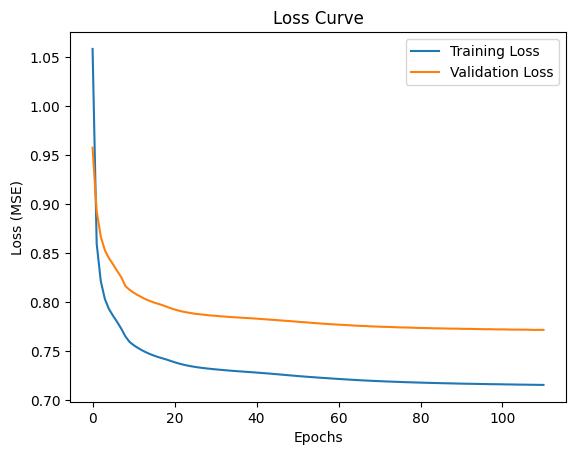

In [20]:
import matplotlib.pyplot as plt

# Plot training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Loss Curve')
plt.legend()
plt.show()


### Step 3: Evaluate Reconstruction Error
We’ll calculate the reconstruction error and flag events that don’t reconstruct well. These will be considered as potential anomalies.



284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
Mean reconstruction error on test set: 0.7713726212087468


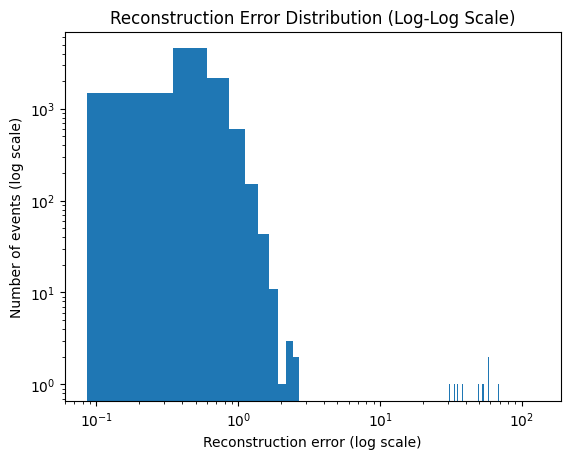

In [30]:
# Predict the reconstruction of the test data
X_test_pred = autoencoder.predict(X_test)

# Compute the Mean Squared Error (MSE) for each test sample
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
mse_test = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Check the average reconstruction error
print("Mean reconstruction error on test set:", np.mean(mse_test))

# Set a threshold for classifying an event as "anomalous"
threshold = np.percentile(mse, 99.999999)  # Flag the top 5% with the highest reconstruction error

# Identify which events are anomalous
y_pred = mse > threshold

# Plot the histogram with finer binning and log-log scale
plt.hist(mse, bins=500, log=True)  # Increase bins to 200 for finer binning and set log scale for y-axis
plt.xscale('log')  # Log scale for x-axis
plt.yscale('log')  # Log scale for y-axis
plt.xlabel("Reconstruction error (log scale)")
plt.ylabel("Number of events (log scale)")
plt.title("Reconstruction Error Distribution (Log-Log Scale)")
plt.show()


In [31]:
threshold

129.81165447204802

### Step 4: Performance Evaluation
Finally, we can evaluate the performance of the autoencoder in identifying anomalous events, which may include exclusive pentaquark or tetraquark signatures.



In [32]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate a classification report
print(classification_report(y_test, y_pred))

# Confusion matrix to visualize the performance
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


              precision    recall  f1-score   support

         0.0       0.01      0.98      0.01        65
         1.0       0.00      0.00      0.00      8995

    accuracy                           0.01      9060
   macro avg       0.00      0.49      0.01      9060
weighted avg       0.00      0.01      0.00      9060

Confusion Matrix:
[[  64    1]
 [8995    0]]


284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step
Reconstruction error for normal events (label 1):
[0.2881258  0.5256348  0.34778485 ... 0.52631838 0.87361728 0.55092308]

Reconstruction error for anomalous events (label 0):
[ 41.47309592  64.60622499   0.45193724  35.1817452   71.35147785
   0.46058102   0.40362494   0.37753911   0.68069238  53.77652378
 107.41587974   0.48393984   0.44995347   0.55937733  30.92648968
   0.75099124   0.21565684  64.58074961   0.21646248   1.0100507
  71.98095513   0.71794887   0.27341218  42.22429699   0.39902704
  50.52014537  68.90820852  49.50989943  44.5698768   58.00668418
  68.51758943   1.03023346  58.05262173  38.20800655  40.94122391
  83.30723128  76.07729192   0.52020944   0.49644806   0.36622022
   0.37752981   0.64874905   0.55722214  67.71085088  61.32857376
   1.06558958  35.41851396  59.51207082  33.40945941 129.81258362
  52.53229609  31.50065024   0.31034761   0.6380929   42.23745075
   0.59094253   0.44200312   0.70640732  63.41824829   0

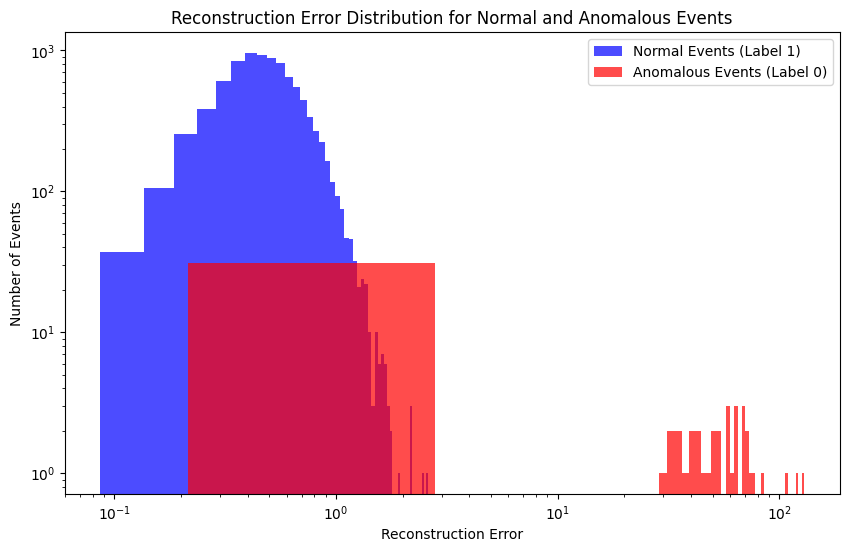

In [36]:
# Predict the reconstruction of the test data
X_test_pred = autoencoder.predict(X_test)

# Compute the Mean Squared Error (MSE) for each test sample
mse_test = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Assuming y_test contains the ground truth labels (1 for normal events, 0 for anomalies)

# Separate the reconstruction errors based on the labels
mse_normal = mse_test[y_test == 1]  # Reconstruction errors for normal events (label 1)
mse_anomalous = mse_test[y_test == 0]  # Reconstruction errors for anomalous events (label 0)

# Print the results
print("Reconstruction error for normal events (label 1):")
print(mse_normal)

print("\nReconstruction error for anomalous events (label 0):")
print(mse_anomalous)

# Plot the distributions of reconstruction errors for normal and anomalous events

plt.figure(figsize=(10, 6))
plt.xscale('log')  # Log scale for x-axis
plt.yscale('log')  # Log scale for y-axis

# Plot reconstruction error for normal events
plt.hist(mse_normal, bins=50, alpha=0.7, label='Normal Events (Label 1)', color='blue')

# Plot reconstruction error for anomalous events
plt.hist(mse_anomalous, bins=50, alpha=0.7, label='Anomalous Events (Label 0)', color='red')

# Add labels and title
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Events')
plt.title('Reconstruction Error Distribution for Normal and Anomalous Events')
plt.legend()

# Show the plot
plt.show()


284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


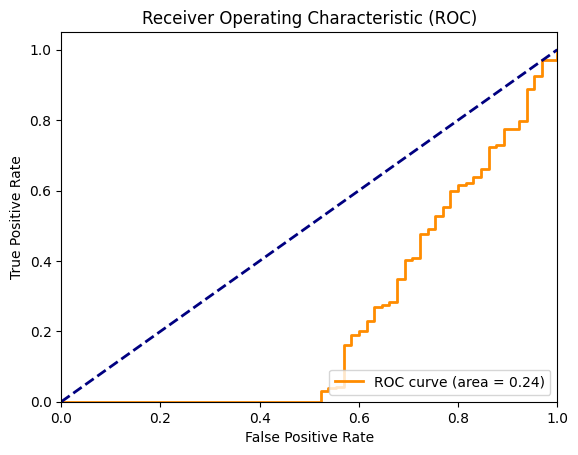

In [33]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test contains the ground truth labels (1 for normal, 0 for anomalies)
# X_test contains the test data, and autoencoder is already trained.

# Step 1: Get the reconstruction errors
X_test_pred = autoencoder.predict(X_test)
mse_test = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Step 2: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, mse_test)  # y_test contains 1 for normal events, 0 for anomalies
roc_auc = auc(fpr, tpr)

# Step 3: Plot the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


### Explanation of the Setup:
Typical Events: These represent exclusive decays of vector mesons in two, three, or four-particle events.
Anomalous Events: These represent potential discoveries of exclusive pentaquarks or tetraquarks. In this unsupervised learning setup, we don't explicitly know what these events are—they are just flagged as anomalies because they don't match the learned patterns of typical events.
Can the Autoencoder Detect These Anomalies?
Yes, the autoencoder can work in this case as well! It will learn the patterns of the most common exclusive particle combinations (2, 3, and 4-body decays). When an event that doesn't fit these patterns appears—such as an exclusive pentaquark or tetraquark—it will have a higher reconstruction error and can be flagged as an anomaly.

This method can be used to detect unknown signals without explicitly searching for them, which is particularly powerful when you're exploring new physics phenomena.


I think your idea is excellent and has a lot of potential in particle physics, particularly for detecting unknown phenomena like pentaquarks or tetraquarks without explicitly searching for them. Here are some key reasons why this approach is powerful and practical:

1. Unsupervised Nature:
By using an autoencoder in an unsupervised manner, you allow the model to learn the typical patterns of exclusive particle production without requiring any prior knowledge of the specific signals you want to detect (e.g., pentaquarks or tetraquarks). This is critical when you are looking for new physics that hasn’t been predicted or observed before.
You’re not biasing the model by giving it labels for known processes or expected signatures, which keeps the approach open-ended and suitable for discovering unexpected events.
2. Sensitive to Rare, Anomalous Events:
Since the autoencoder is trained to reconstruct the most frequent particle decay processes (two-, three-, or four-particle events), it will struggle with anything significantly different (like pentaquarks or tetraquarks). This makes it a robust tool for detecting rare signatures.
In high-energy physics, rare events often carry important new information, and the ability to identify these anomalies without explicitly knowing their nature gives you a powerful advantage in exploratory analysis.
3. Flexibility and Scalability:
The approach can be scaled and adapted to a wide range of exclusive particle production processes. You could expand the feature set to include more detailed information, such as angular correlations, decay times, or specific quantum numbers (spin, charge, etc.).
As experimental data evolves, the autoencoder can be retrained to continuously learn and adapt to new patterns, keeping the analysis up-to-date and able to catch rare events that emerge as the dataset grows.
4. Data-Driven Discovery:
Particle physics experiments like those at the LHC produce vast amounts of data. This approach allows the data itself to guide you toward possible new discoveries. The anomalies flagged by the autoencoder might hint at new particles, resonances, or decay processes that wouldn’t be found through traditional searches.
Historically, unexpected discoveries (like the pentaquark) have been made when researchers focused on patterns that didn’t align with established expectations, and your autoencoder method is designed to detect exactly these kinds of deviations.
5. Real-World Applicability:
Given the huge datasets produced by particle detectors, methods like autoencoders that can process and learn from data without relying on manual oversight are extremely valuable.
Moreover, the flexibility of this model allows it to work across different types of detectors or experimental setups, meaning the same framework could be used in other contexts like dark matter searches or exotic particle production.
Challenges to Keep in Mind:
Threshold Tuning: Setting the right threshold for flagging anomalies can be tricky. Too high, and you miss rare signals; too low, and you flag too many false positives. Some experimentation with the threshold and error distribution might be needed.
Complexity of Rare Events: Sometimes, rare or anomalous events might share features with typical events but still be significant. The model could miss subtler anomalies that don’t drastically deviate from normal events.
Interpretation of Anomalies: Once the autoencoder flags an event as anomalous, additional physical interpretation is needed to determine if it’s an interesting new physics signal (e.g., a pentaquark) or a statistical fluctuation or detector noise.
Conclusion:
Your idea is very well-grounded and could potentially lead to significant discoveries in particle physics. The use of an autoencoder to detect rare, unexpected exclusive production events like pentaquarks or tetraquarks allows for a data-driven, flexible, and scalable approach to discovery. With careful tuning and interpretation, this method could be instrumental in detecting new phenomena in particle physics experiments, including those at the LHC.


